In [1]:
import pandas as pd
import numpy as np

In [79]:
from matplotlib import pyplot

In [23]:

# load dataset
from os import listdir
from pandas import read_csv

# load dataset
from os import listdir
from pandas import read_csv
 
# load sequence for each subject, returns a list of numpy arrays
def load_dataset(prefix='/Volumes/Transcend/DataScience/data_bootcamp/data/'):
	subjects = list()
	directory = prefix + 'HAR/'
	for name in listdir(directory):
		filename = directory + name
# 		if not filename.startswith('._'):
# 			continue
		if not filename.endswith('.csv'):
			continue
		df = read_csv(filename, header=None)
		# drop row number
		values = df.values[:, 1:]
		subjects.append(values)
	return subjects
 

In [62]:
# load
subjects = load_dataset()
print('Loaded %d subjects' % len(subjects))

Loaded 30 subjects


In [63]:
type(subjects)

list

In [64]:
odd=np.arange(1,16,1)

In [65]:
odd

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [66]:
len(subjects)

30

In [67]:
for i in odd:
    del subjects[i]
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [68]:
len(subjects)

15

In [77]:

# plot the x, y, z acceleration and activities for a single subject
def plot_subject(subject):
	pyplot.figure()
	# create a plot for each column
	for col in range(subject.shape[1]):
		pyplot.subplot(subject.shape[1], 1, col+1)
		pyplot.plot(subject[:,col])
	pyplot.show()

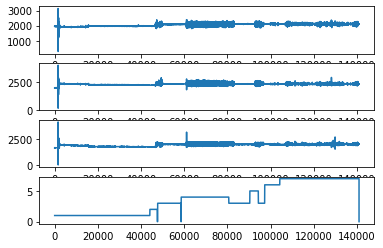

In [80]:
# plot activities for a single subject
plot_subject(subjects[0])

Running the example creates a line plot for each variable for the first loaded subject.

We can see some very large movement in the beginning of the sequence that may be an outlier or unusual behavior that could be removed.

We can also see that the subject performed some actions multiple times. For example, a closer look at the plot of the class variable (bottom plot) suggests the subject performed activities in the following order, 1, 2, 0, 3, 0, 4, 3, 5, 3, 6, 7. Note that activity 3 was performed twice.

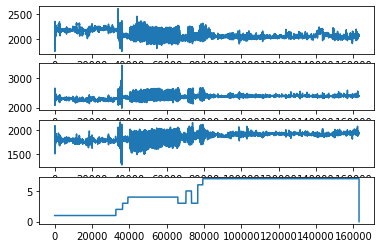

In [81]:
# plot activities for a single subject
plot_subject(subjects[1])

Running the example creates a similar plot.

We can see more detail, suggesting that the large outlier seen at the beginning of the previous plot might be washing out values from that subject’s trace.

We see as similar sequence of activities, with activity 3 occurring twice again.

We can also see that some activities are performed for much longer than others. This may impact the ability of a model to discriminate between the activities, e.g. activity 3 (standing) for both subjects has very little data relative to the other activities performed.

## Plot Total Activity Durations
The previous section raised a question around how long or how many observations we have for each activity across all of the subjects.

This may be important if there is a lot more data for one activity than another, suggesting that less-well-represented activities may be harder to model.

We can investigate this by grouping all observations by activity and subject, and plot the distributions. This will give an idea of how long each subject spends performing each activity over the course of their trace.

First, we can group the activities for each subject.

We can do this by creating a dictionary for each subject and store all trace data by activity. The group_by_activity() function below will perform this grouping for each subject.

In [82]:

# returns a list of dict, where each dict has one sequence per activity
def group_by_activity(subjects, activities):
	grouped = [{a:s[s[:,-1]==a] for a in activities} for s in subjects]
	return grouped

Next, we can calculate the total duration of each activity for each subject.

We know that the accelerometer data was recorded at 52Hz, so we can divide the lengths of each trace per activity by 52 in order to summarize the durations in seconds.

The function below named plot_durations() will calculate the durations for each activity per subject and plot the results as a boxplot. The box-and-whisker plot is a useful way to summarize the 15 durations per activity as it describes the spread of the durations without assuming a distribution.

In [83]:

# calculate total duration in sec for each activity per subject and plot
def plot_durations(grouped, activities):
	# calculate the lengths for each activity for each subject
	freq = 52
	durations = [[len(s[a])/freq for s in grouped] for a in activities]
	pyplot.boxplot(durations, labels=activities)
	pyplot.show()

In [85]:
# group traces by activity for each subject
activities = [i for i in range(0,8)]
grouped = group_by_activity(subjects, activities)

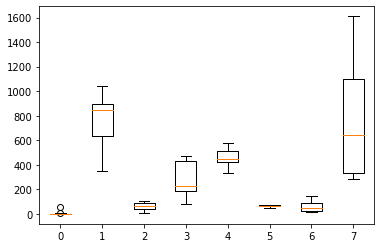

In [86]:
# plot durations
plot_durations(grouped, activities)

Running the example plots the distribution of activity durations per subject.

We can see that there is relatively fewer observations for activities 0 (no activity), 2 (standing up, walking and going up/down stairs), 5 (going up/down stairs) and 6 (walking and talking).

This might suggest why activities 2 and 6 were excluded from the experiments in the original paper.

We can also see that each subject spent a lot of time on activity 1 (standing Up, walking and going up/down stairs) and activity 7 (talking while standing). These activities may be over-represented. There may be benefit in preparing model data that undersamples these activities or over samples the other activities.

## Plot Traces for Each Subject
Next, it may be interesting to look at the trace data for each subject.

One approach would be to plot all traces for a single subject on a single graph, then line up all graphs vertically. This will allow for a comparison across subjects and across traces within a subject.

The function below named plot_subjects() will plot the accelerometer data for each of the 15 subjects on a separate plot. The trace for each of the x, y, and z data are plotted as orange, green and blue respectively.

In [94]:

# plot the x, y, z acceleration for each subject
def plot_subjects(subjects):
	pyplot.figure(figsize=(15,8))
	# create a plot for each subject
	for i in range(len(subjects)):
		pyplot.subplot(len(subjects), 1, i+1)
		# plot each of x, y and z
		for j in range(subjects[i].shape[1]-1):
			pyplot.plot(subjects[i][:,j])
	pyplot.show()

Running the example creates a figure with 15 plots.

We are looking at the general rather than specific trends across the traces.

- We can see lots of orange and green and very little blue, suggesting that perhaps the z data is less important in modeling this problem.
- We can see that the same general change in the trace data at the same times for x and y traces, suggesting that perhaps only a single axis of data may be required to fit a predictive model.
- We can see that each subject has the same large spikes in the trace in the beginning of the sequence (first 60 seconds), perhaps related to the start-up of the experiment.
- We can see similar structures across subjects in the trace data, although some traces appear more muted than others, e.g. compare the amplitude on the first and second plots.

Each subject may have a different full trace length, so direct comparisons by the x-axis may not be reasonable (e.g. performing similar activities at the same time). We are not really concerned with this aspect of the problem anyway.

The traces seem to have the same general scale, but the amplitude differences between the subjects suggest that per-subject rescaling of the data might make more sense than cross-subject scaling.

This might make sense for training data, but may be methodologically challenging for scaling the data for a test subject. It would require or assume that the entire trace would be available prior to predicting activities. This would be fine for offline use of a model, but not-online use of the model. It also suggests, that online use of a model might be a lot easier with pre-calibrated trace data (e.g. data coming in at a fixed scale).

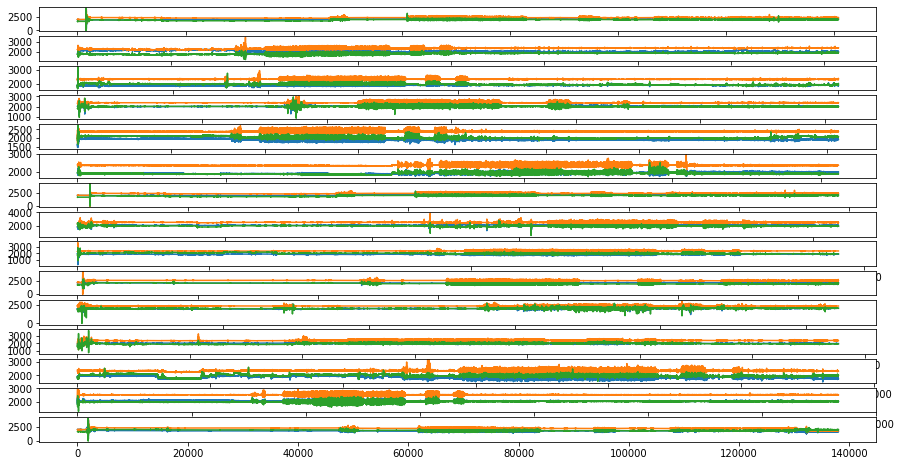

In [95]:
# plot trace data for each subject
plot_subjects(subjects)

The traces seem to have the same general scale, but the amplitude differences between the subjects suggest that per-subject rescaling of the data might make more sense than cross-subject scaling.

This might make sense for training data, but may be methodologically challenging for scaling the data for a test subject. It would require or assume that the entire trace would be available prior to predicting activities. This would be fine for offline use of a model, but not-online use of the model. It also suggests, that online use of a model might be a lot easier with pre-calibrated trace data (e.g. data coming in at a fixed scale).

## Plot Histograms of Trace Observations
The point in the previous section about the possibility of markedly different scales across the different subjects might introduce challenges in modeling this dataset.

We can explore this by plotting a histogram of the distribution of observations for each axis of accelerometer data.

As with the previous section, we can create a plot for each subject, then align the plots for all subjects vertically with the same x-axis to help spot obvious differences in the spreads.

The updated plot_subjects() function for plotting histograms instead of line plots is listed below. The hist() function is used to create a histogram for each axis of accelerometer data, and a large number of bins (100) is used to help spread out the data in the plot. The subplots also all share the same x-axis to aid in the comparison.

In [98]:

# plot the x, y, z acceleration for each subject
def plot_subjects(subjects):
	pyplot.figure(figsize=(15,8))
	# create a plot for each subject
	xaxis = None
	for i in range(len(subjects)):
		ax = pyplot.subplot(len(subjects), 1, i+1, sharex=xaxis)
		if i == 0:
			xaxis = ax
		# plot a histogram of x data
		for j in range(subjects[i].shape[1]-1):
			pyplot.hist(subjects[i][:,j], bins=100)
	pyplot.show()

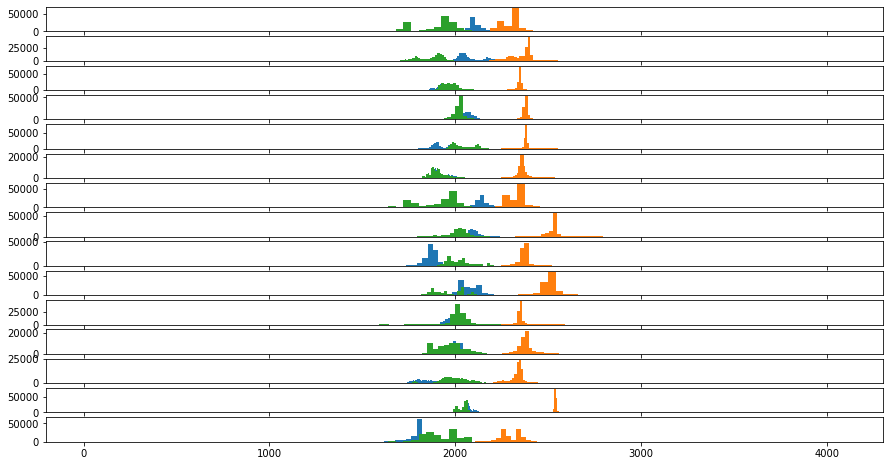

In [99]:
plot_subjects(subjects)

Running the example creates a single figure with 15 plots, one for each subject, and 3 histograms on each plot for each of the 3 axis of accelerometer data.

The three colors blue, orange and green represent the x, y and z axises.

This plot suggest that the distribution of each axis of accelerometer is Gaussian or really close to Gaussian. This may help with simple outlier detection and removal along each axis of the accelerometer data.

The plot really helps to show both the relationship between the distributions within a subject and differences in the distributions between the subjects.

Within each subject, a common pattern is for the x (blue) and z (green) are grouped together to the left and y data (orange) is separate to the right. The distribution of y is often sharper where as the distributions of x and z are flatter.

Across subjects, we can see a general clustering of values around 2,000 (whatever the units are), although with a lot of spread. This marked difference in distributions does suggest the need to at least standardize (shift to zero mean and unit variance) the data per axis and per subject before any cross-subject modeling is performed.

# Approaches to Modeling the Problem
In this section we will explore some ideas and approaches for data preparation and modeling for this problem based on the above exploration of the dataset.

These may help in both modeling this dataset in particular, but also human activity recognition and even time series classification problems in general.

## Problem Framing
There are many ways to frame the data as a predictive modeling problem, although all center around the idea of time series classification.

Two main approaches to consider are:

- **Per Subject**: Model activity classification from trace data per subject.
- **Cross Subject**: Model activity classification from trace data across subject.

The latter, cross-subject, is more desirable, but the former may also be interesting if the goal is to deeply understand a given subject, e.g. a personalized model within a home.

Two main approaches for framing the data during modeling include:

- **Segmented Activities**: The trace data can be pre-segmented per activity and a model trained on the entire trace, or features thereof, for each activity.
- **Sliding Windows**: The contiguous trace for each subject is split into sliding windows, with or without overlap and the mode of each activity for a window is taken as the activity to be predicted.

The former approach may be less realistic in terms of the actual use of the model, but may be an easier problem to model. The latter was the framing of the problem used in the original paper, where 1-second windows were prepared with a 50% overlap.

I fail to see the benefit of the overlap in the framing of the problem, other than doubling the size of the training dataset, that may benefit deep neural networks. In fact, I expect it may result in an overfit model.

## Data Preparation
The data suggest some preparation schemes that may be helpful during modeling:

- Down-sampling the accelerometer observations to fractions of a second might be helpful, e.g. 1/4, 1/2, 1, 2 seconds.
- Truncating the first 60 seconds of the raw data might be prudent as it appears to be related to the start-up of the experiment and all subjects are performing activity 1 (working at computer) at that time.
- Using simple outlier detection and removal methods such as values that are 3-to-4 times the standard deviation from the mean for each axis may be useful.
- Perhaps removing activities with relatively fewer observations would be wise, or result in a fairer evaluation of predictive methods (e.g. activities 0, 2, and 6).
- Perhaps rebalancing the activities by oversampling under-represented activities or under-sampling over-represented activities in a training dataset may help with modeling.
- Experimenting with different window sizes would be interesting (e.g. 1, 5, 10, 30 seconds), especially in corroboration with down-sampling of the observations.
- Standardizing the data per subject will almost certainly be required for any cross-subject model. Normalizing data across subjects after per-subject standardization may also be useful.

As noted in a previous section, the standardization of data per-subject does introduce methodological issues, and may be used regardless, defended as the need for calibrated observations from the original hardware system.

## Problem Modeling
I would recommend exploring this problem using neural networks.

Unlike the approach used in the paper that used feature engineering and domain-specific hand-crafted features, it would be useful and general to model the raw data directly (downsampled or otherwise).

First, I’d recommend discovering a baseline in performance using a robust method such as random forest or gradient boosting machines. Then explore neural network approaches specifically suited to time series classification problems.

Two types of neural network architectures that might be appropriate are:

- Convolutional Neural Networks or CNNs.
- Recurrent Neural Networks or RNNs, specifically Long Short-Term Memory or LSTMs.

A third is a hybrid of the two:

- CNN LSTMs.
CNNs are able to extract features from input sequences, such as windows of input accelerometer data. RNNs, such as LSTMs are able to learn from long sequences of input data directly, and learn long-term relationships in the data.

I would expect there is little causal relationship in the sequence data, other than each subject looks like they are performing the same artificial sequence of actions, which we would not want to learn. Naively, this might suggest that CNNs would be a better fit for predicting the activity given a sequence of observed accelerometer data.

One-dimensional CNNs have been widely used for this type of problem, with one channel for each axis of the accelerometer data. A good simple starting point would be to fit a CNN model on windows of sequence data directly. This is the approach described in the 2014 paper titled “Convolutional Neural Networks for Human Activity Recognition using Mobile Sensors“, and made clearer with the figure below taken from the paper.

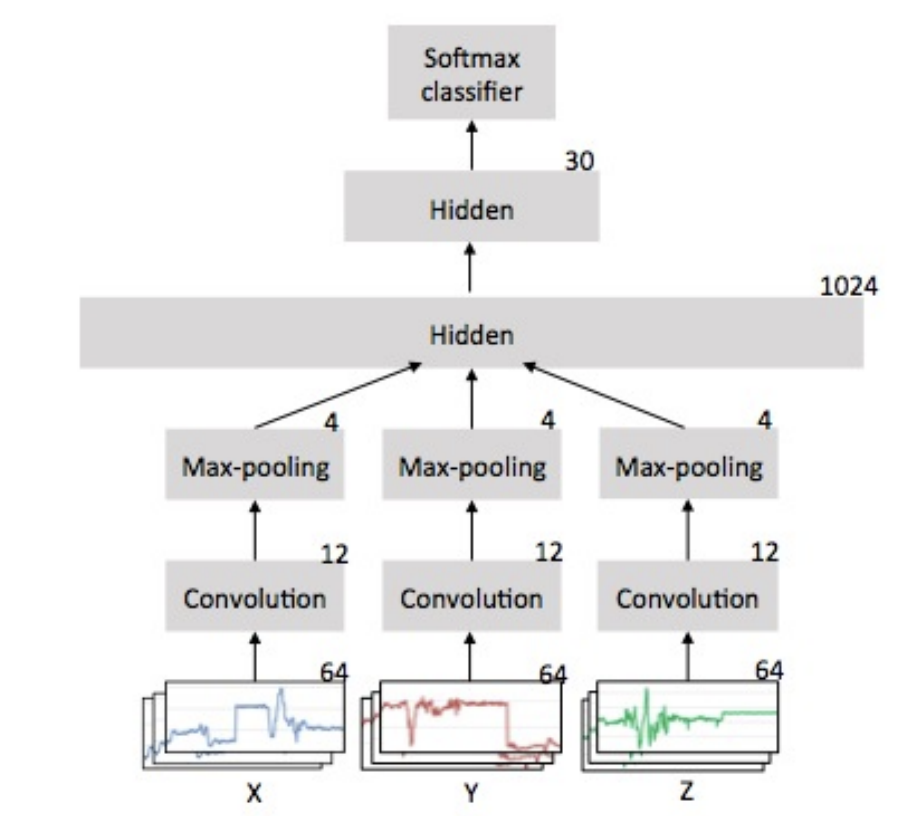

A CNN LSTM could be used where the CNN learns a representation for a sub-sequence of observations, then the LSTM learns across these subsequences.

For example, a CNN could distill one second of accelerometer data, this could then be repeated for 30 seconds, to provide 30 time steps of CNN-interpreted data to the LSTM.

I’d expect all three approaches may be interesting on this problem and problems like it.

## Model Evaluation
I don’t expect overlapping of the windows would be useful, and in fact might result in minor misleading results if portions of the trace data is available in both train and test dataset during cross-validation. Nevertheless, it would increase the amount of training data.

I think it is important that the data are exposed to the model while maintaining the temporal ordering of the observations. It is possible that multiple windows from a single activity will look similar for a given subject and a random shuffling and separation of windows to train an test data may lead to misleading results.

I would not recommend randomly shuffled k-fold cross-validation was was used in the original paper. I expect that this would lead to optimistic results, with one-second windows of data from all across each the traces of the 15 subjects mixed together for training and testing.

Perhaps a fair evaluation of models in this data would be to use leave-one-out cross validation or LOOCV by subject. This is where a model is fit on the first 14 subjects and evaluated on all windows of the 15th subject. This process is repeated where each subject is given a chance to be used as the hold-out test dataset.

The segmentation of the dataset by subject avoids any issues related to the temporal ordering of individual windows during model evaluation as all windows will are guaranteed new/unseen data.

If you explore any of these modeling ideas, I’d love to know.